In [ ]:
from keras.models import Sequential
from keras.utils import get_file, to_categorical
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout, SimpleRNN
from keras.layers import GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.preprocessing.text import Tokenizer

import os
import glob
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

!pip install navec
from navec import Navec
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

data_path = get_file(
    "russian_literature.zip",
    "https://storage.yandexcloud.net/academy.ai/russian_literature.zip"
)

!unzip -qo "{data_path}" -d ./dataset

FILE_DIR_POEMS = './dataset/poems'
FILE_DIR_PROSE = './dataset/prose'

file_list_poems = os.listdir(FILE_DIR_POEMS)
file_list_prose = os.listdir(FILE_DIR_PROSE)

print("Поэты:")
print(file_list_poems)

print("Прозаики:")
print(file_list_prose)

CLASS_LIST = list(set(file_list_poems + file_list_prose))
print("Общий список писателей:")
print(CLASS_LIST)

all_texts = {}
for author in CLASS_LIST:
    all_texts[author] = ''
    for path in glob.glob(f'./dataset/prose/{author}/*.txt') + glob.glob(f'./dataset/poems/{author}/*.txt'):
        with open(f'{path}', 'r', errors='ignore') as f:
            text = f.read()
        all_texts[author] += ' ' + text.replace('\n', ' ')


--2024-05-29 23:56:27--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar.2’

navec_hudlit_v1_12B 100%[===================>]  50.56M  17.6MB/s    in 2.9s    

2024-05-29 23:56:30 (17.6 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar.2’ saved [53012480/53012480]

error:  cannot create ./dataset/poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
error:  cannot create ./dataset/prose/Gogol/╨Я╨╛╨▓╨╡╤Б╤В╤М ╨╛ ╤В╨╛╨╝, ╨║╨░╨║ ╨┐╨╛╤Б╤Б╨╛╤А╨╕╨╗╤Б╤П ╨Ш╨▓╨░╨╜ ╨Ш╨▓╨░╨╜╨╛╨▓╨╕╤З ╤Б ╨Ш╨▓╨░╨╜╨╛╨╝ ╨Э╨╕╨║╨╕╤Д╨╛╤А╨╛╨▓╨╕╤З╨╡╨╝.txt
        File n

In [ ]:
# Параметры для токенизации и создания эмбедингов
embedding_dim = 300
max_words = 15000

# Токенизация текстов
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True)
tokenizer.fit_on_texts(all_texts.values())
seq_train = tokenizer.texts_to_sequences(all_texts.values())

# Вывод статистики по данным
total = sum(len(i) for i in seq_train)
print(f'Датасет состоит из {total} слов')

mean_list = np.array([len(seq) for seq in seq_train])
print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

median = int(np.median(mean_list))
CLASS_LIST_BALANCE = []
seq_train_balance = []
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    if len(seq_train[cls]) > median * 0.6:
        seq_train_balance.append(seq_train[cls][:median])
        CLASS_LIST_BALANCE.append(author)

# Вывод сбалансированной выборки
total = sum(len(i) for i in seq_train_balance)
mean_list_balance = np.array([len(seq) for seq in seq_train_balance])
print('Среднее значение слов: ', np.round(mean_list_balance.mean()))
print('Медианное значение слов: ', np.median(mean_list_balance))


Датасет состоит из 4990033 слов
Среднее значение слов:  415836.0
Медианное значение слов:  261136.5
Среднее значение слов:  247491.0
Медианное значение слов:  261136.0


In [ ]:
WIN_SIZE = 1000
WIN_STEP = 100

# Функция разбиения последовательности на отрезки скользящим окном
def seq_split(sequence, win_size, step):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

# Модифицированная функция для разбиения на три выборки
def seq_vectorize(seq_list, train_split, val_split, class_list, win_size, step):
    x_train, y_train, x_val, y_val, x_test, y_test = [], [], [], [], [], []

    for class_item in class_list:
        cls = class_list.index(class_item)
        train_gate_split = int(len(seq_list[cls]) * train_split)
        val_gate_split = int(len(seq_list[cls]) * (train_split + val_split))

        vectors_train = seq_split(seq_list[cls][:train_gate_split], win_size, step)
        vectors_val = seq_split(seq_list[cls][train_gate_split:val_gate_split], win_size, step)
        vectors_test = seq_split(seq_list[cls][val_gate_split:], win_size, step)

        x_train += vectors_train
        x_val += vectors_val
        x_test += vectors_test

        y_train += [to_categorical(cls, len(class_list))] * len(vectors_train)
        y_val += [to_categorical(cls, len(class_list))] * len(vectors_val)
        y_test += [to_categorical(cls, len(class_list))] * len(vectors_test)

    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)

train_split = 0.8
val_split = 0.1

x_train, y_train, x_val, y_val, x_test, y_test = seq_vectorize(seq_train_balance, train_split, val_split, CLASS_LIST_BALANCE, WIN_SIZE, WIN_STEP)


In [ ]:
def loadEmbedding(model):
    word_index = tokenizer.word_index
    embeddings_index = navec

    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    return model

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Bidirectional(LSTM(8)))
model.add(RepeatVector(WIN_SIZE))
model.add(GRU(16, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.3))
model.add(Dense(100, activation='relu'))
model.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

model = loadEmbedding(model)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

def show_plot(history, title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели: ' + title)
    ax1.plot(history.history['accuracy'], label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'], label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'], label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

def show_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), normalize='true')
    cm = np.around(cm, 3)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)
    plt.show()

    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


Epoch 1/50
124/124 [==============================] - ETA: 0s - loss: 1.9421 - accuracy: 0.2121
Epoch 1: val_accuracy improved from -inf to 0.18206, saving model to best_model.h5
124/124 [==============================] - 31s 169ms/step - loss: 1.9421 - accuracy: 0.2121 - val_loss: 2.0219 - val_accuracy: 0.1821
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - ETA: 0s - loss: 1.7502 - accuracy: 0.2628
Epoch 2: val_accuracy improved from 0.18206 to 0.28541, saving model to best_model.h5
124/124 [==============================] - 19s 156ms/step - loss: 1.7502 - accuracy: 0.2628 - val_loss: 1.8886 - val_accuracy: 0.2854
Epoch 3/50
124/124 [==============================] - ETA: 0s - loss: 1.6203 - accuracy: 0.3313
Epoch 3: val_accuracy improved from 0.28541 to 0.29538, saving model to best_model.h5
124/124 [==============================] - 19s 150ms/step - loss: 1.6203 - accuracy: 0.3313 - val_loss: 1.7847 - val_accuracy: 0.2954
Epoch 4/50
124/124 [==============================] - ETA: 0s - loss: 1.3461 - accuracy: 0.4703
Epoch 4: val_accuracy improved from 0.29538 to 0.46275, saving model to best_model.h5
124/124 [==============================] - 20s 159ms/step - loss: 1.3461 - accuracy: 0.4703 - val_loss: 1.4229 - val_accuracy: 0.4627
Epoch 5/50
124/124 [==============================] - ETA: 0s -

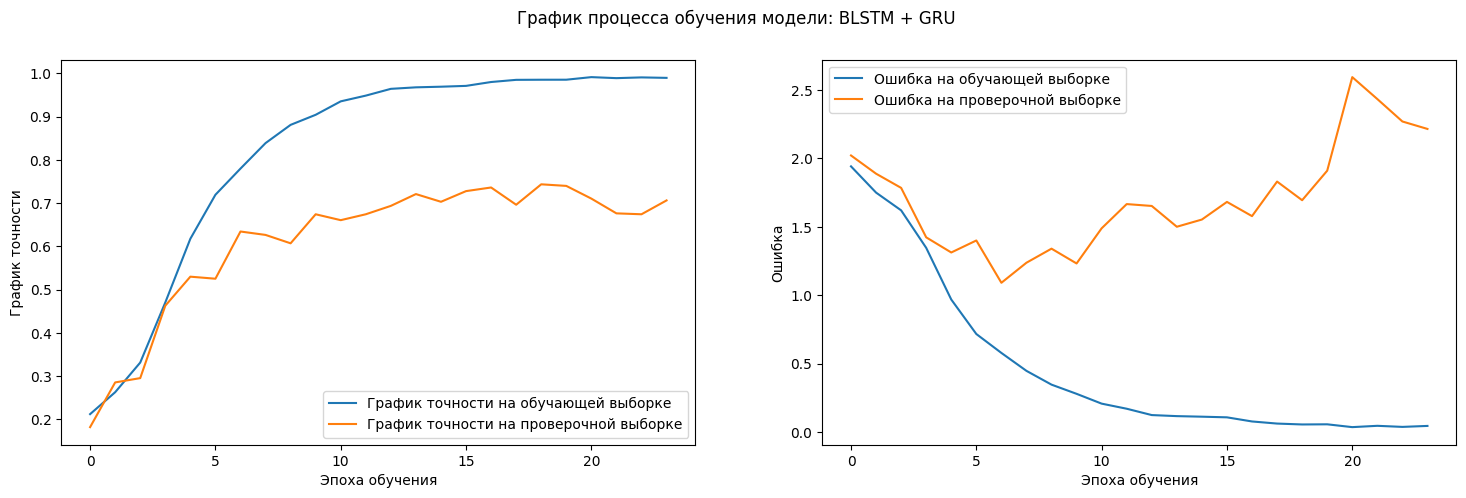

60/60 [==============================] - 5s 63ms/step


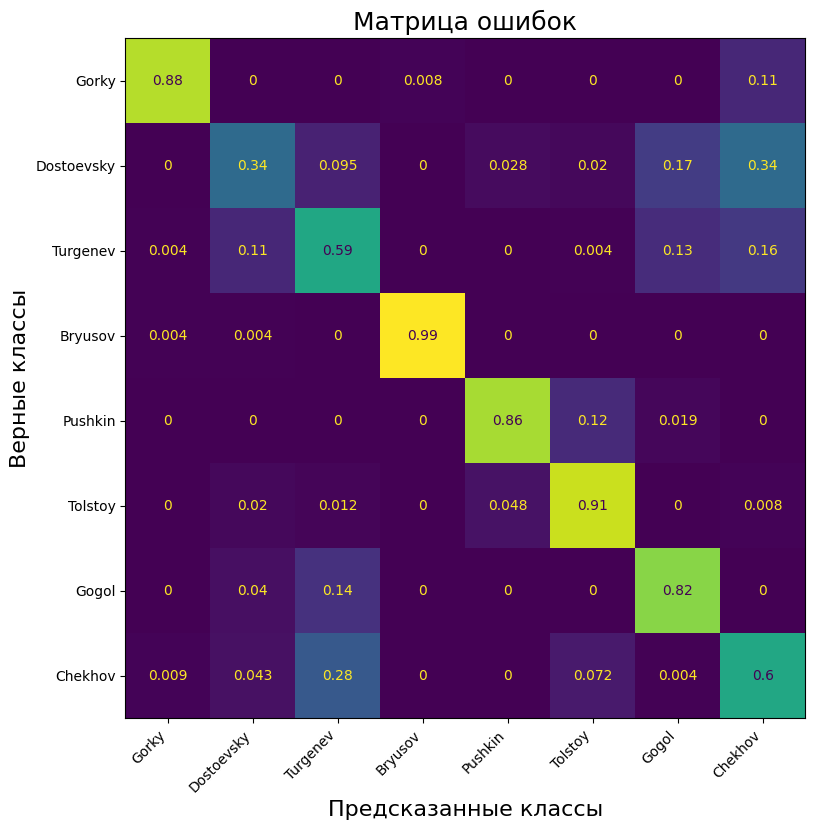


Средняя точность распознавания:  75%


In [ ]:
# Создание колбэков для сохранения лучшей модели
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

# Обучение модели
history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint, early_stopping])

# Загрузка лучшей модели
model.load_weights('best_model.h5')

# Построение графиков процесса обучения
show_plot(history, title='BLSTM + GRU')

# Оценка на тестовых данных
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST_BALANCE)


1/1 [==============================] - 0s 78ms/step
Ваш текст похож на произведения автора: Gorky


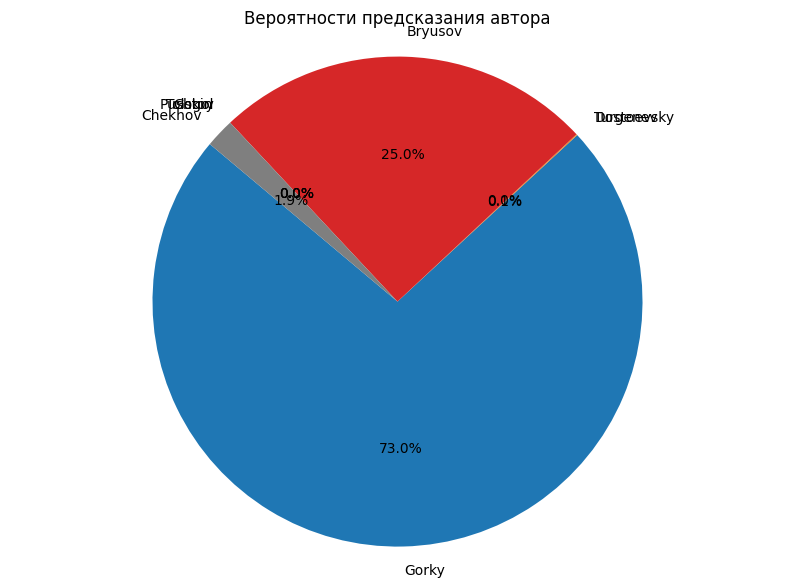

In [ ]:
# Функция для предсказания автора текста
def predict_author(text):
    sequence = tokenizer.texts_to_sequences([text])
    sequence = [item for sublist in sequence for item in sublist]  # Flatten the list
    if len(sequence) < WIN_SIZE:
        sequence = [0] * (WIN_SIZE - len(sequence)) + sequence  # Padding
    else:
        sequence = sequence[:WIN_SIZE]

    sequence = np.array([sequence])
    pred = model.predict(sequence)
    return pred

#текст для предсказания
my_text = """
Вечер был тихий и спокойный. Лишь изредка можно было услышать крики птиц, нарушающих умиротворение леса.
Мягкие лучи заходящего солнца, пробиваясь сквозь листву, создавали на земле причудливые узоры.
"""

# Предсказание автора
prediction = predict_author(my_text)
predicted_author = CLASS_LIST_BALANCE[np.argmax(prediction)]
print(f'Ваш текст похож на произведения автора: {predicted_author}')

# Построение круговой диаграммы
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.pie(prediction[0], labels=CLASS_LIST_BALANCE, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Вероятности предсказания автора')
plt.show()
